In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

CRED = '\033[91m'
CEND = '\033[0m'

# Load Images Using imageio.imread

In [ ]:
from imageio import imread

im_path = './inputs/content/C16.jpg'
x = imread(im_path).astype(np.float32)
x = torch.from_numpy(x).contiguous().permute(2, 0, 1).contiguous()
x = F.interpolate(x.unsqueeze(0), (100, 100), mode='bilinear', align_corners=True)

print(x.shape)

# Bilinear Interpolation
- test for downsampling
- test for upsampling

In [2]:
a = torch.arange(1, 17, dtype=torch.float32).view(1, 1, 4, 4)


print(CRED + '------ Down Sampling -----' + CEND)
a = F.interpolate(a, (2, 2), mode='bilinear', align_corners=True)
print(a)


print(CRED + '------ Up Sampling -----' + CEND)
a = F.interpolate(a, (6, 6), mode='bilinear', align_corners=True)
print(a)

------ Down Sampling -----
tensor([[[[ 1.,  4.],
          [13., 16.]]]])
------ Up Sampling -----
tensor([[[[ 1.0000,  1.6000,  2.2000,  2.8000,  3.4000,  4.0000],
          [ 3.4000,  4.0000,  4.6000,  5.2000,  5.8000,  6.4000],
          [ 5.8000,  6.4000,  7.0000,  7.6000,  8.2000,  8.8000],
          [ 8.2000,  8.8000,  9.4000, 10.0000, 10.6000, 11.2000],
          [10.6000, 11.2000, 11.8000, 12.4000, 13.0000, 13.6000],
          [13.0000, 13.6000, 14.2000, 14.8000, 15.4000, 16.0000]]]])


# Hyper-columns & Bilinear Interpolation
- VGG-16 Structure
- Output After Selected Conv Layers
- Output of Bilinear Interpolation

In [3]:
from torchvision import models


print(CRED + '------ VGG-16 Structure -----' + CEND)
vgg = models.vgg16(pretrained=True).features
print(vgg)


x = torch.randn(1, 3, 512, 512)
# idx = [1, 3, 6, 8, 11, 13, 15, 22, 29]
idx = [1, 3, 6, 8, 11, 13, 15, 18, 20, 22, 25, 27, 29]


print(CRED + '------ After Conv -----' + CEND)
l1 = []
for i in range(max(idx) + 1):
    x = vgg[i](x)
    if i in idx:
        print(x.shape)
        l1.append(x)

        
l2 = []
for i in l1:
    if len(l2) == 0:
        l2.append(i)
    else:
        l2.append(F.interpolate(i, (512, 512), mode='bilinear', align_corners=True))


print(CRED + '------ After Interpolate -----' + CEND) 
for i in l2:
    print(i.shape)

        
print(CRED + '------ Output Shape -----' + CEND)
z = torch.cat(l2, 1)
print(z.shape)

------ VGG-16 Structure -----
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (1

# Define the Laplacian function
- dec_pyr()
- syn_pyr()

In [4]:
# Laplacian pyramid processing
def dec_pyr(x, levs):
    pyr = []
    cur = x
    for i in range(levs):
        h = cur.shape[2]
        w = cur.shape[3]
        img_small = F.interpolate(cur, (h // 2, w // 2), mode='bilinear', align_corners=True)
        img_back = F.interpolate(img_small, (h, w), mode='bilinear', align_corners=True)
        lap = cur - img_back
        pyr.append(lap)

        cur = img_small
    pyr.append(cur)
    return pyr


# DeLaplacian pyramid processing
def syn_pyr(pyr):
    levs = len(pyr)
    cur = pyr[-1]
    for i in range(0, levs - 1)[::-1]:
        up_x = pyr[i].size(2)
        up_y = pyr[i].size(3)
        cur = pyr[i] + F.interpolate(cur, (up_x, up_y), mode='bilinear', align_corners=True)
    return cur

# Laplacian Pyramid
- Take image as input and display
- dec_pyr(image, i): tensor [1, 3, H, W]-> list ith elments [1, 3, H/2**(i-1), W/2**(i-1)]
- Display each image in pyr

------ Original Image -----


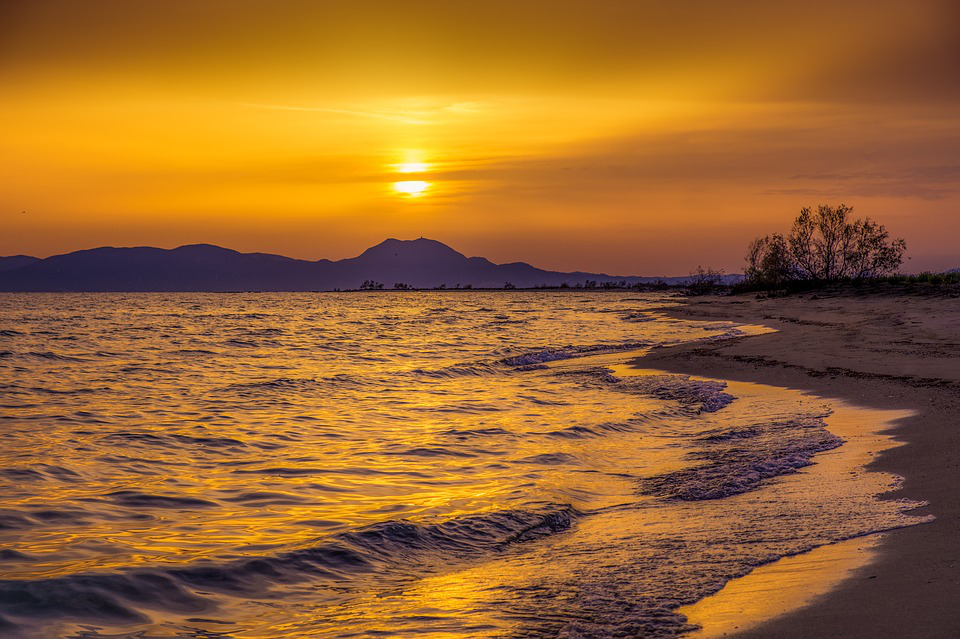

Image size:  torch.Size([1, 3, 639, 960])
------ After Laplacian -----
Number of elements in pyr: 5
Image size:  torch.Size([1, 3, 639, 960])


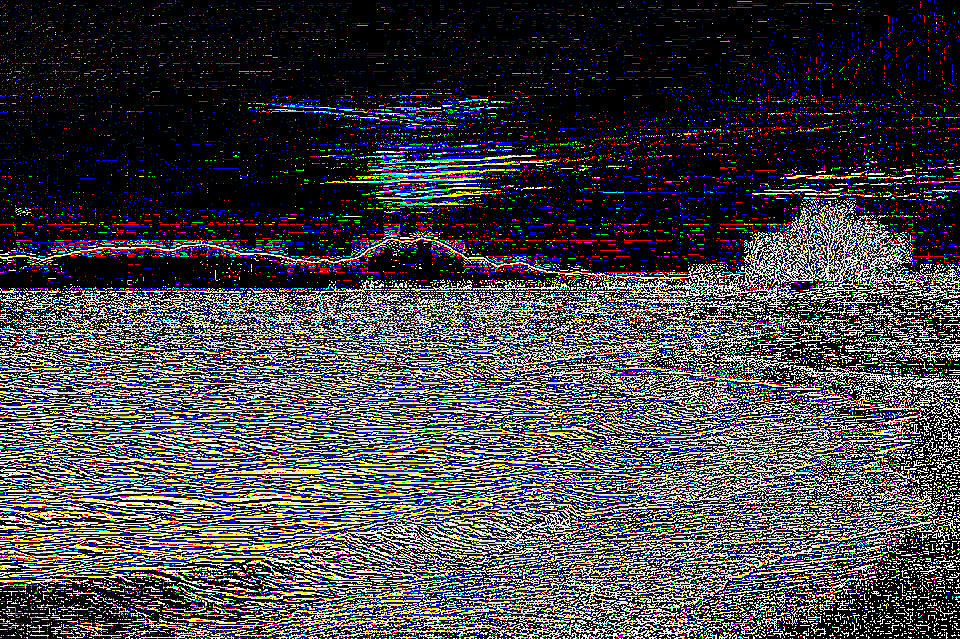

Image size:  torch.Size([1, 3, 319, 480])


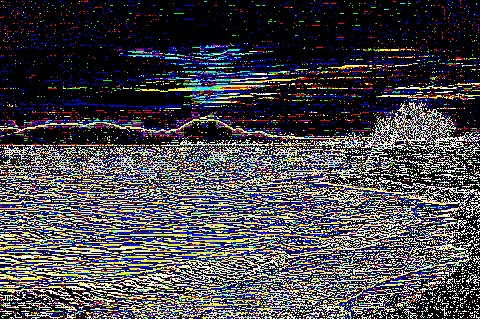

Image size:  torch.Size([1, 3, 159, 240])


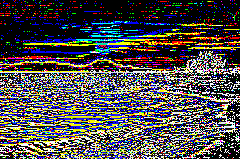

Image size:  torch.Size([1, 3, 79, 120])


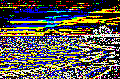

Image size:  torch.Size([1, 3, 39, 60])


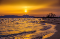

In [14]:
import torchvision
from PIL import Image


print(CRED + '------ Original Image -----' + CEND)
img = Image.open('./inputs/content/C15.jpg')
display(img)


# Load image
img = np.array(img)
img = img / 255.
img = torch.from_numpy(img).unsqueeze(0)
img = torch.permute(img, (0, 3, 1, 2))
print('Image size: ', img.shape)


pyr = dec_pyr(img, 4)


print(CRED + '------ After Laplacian -----' + CEND)
trans = torchvision.transforms.ToPILImage()
print('Number of elements in pyr:', len(pyr))
for i in pyr:
    print('Image size: ', i.shape)
    i = trans(i[0])
    display(i)

# DeLaplacian Pyramid
- Take pyr as input and return the original image

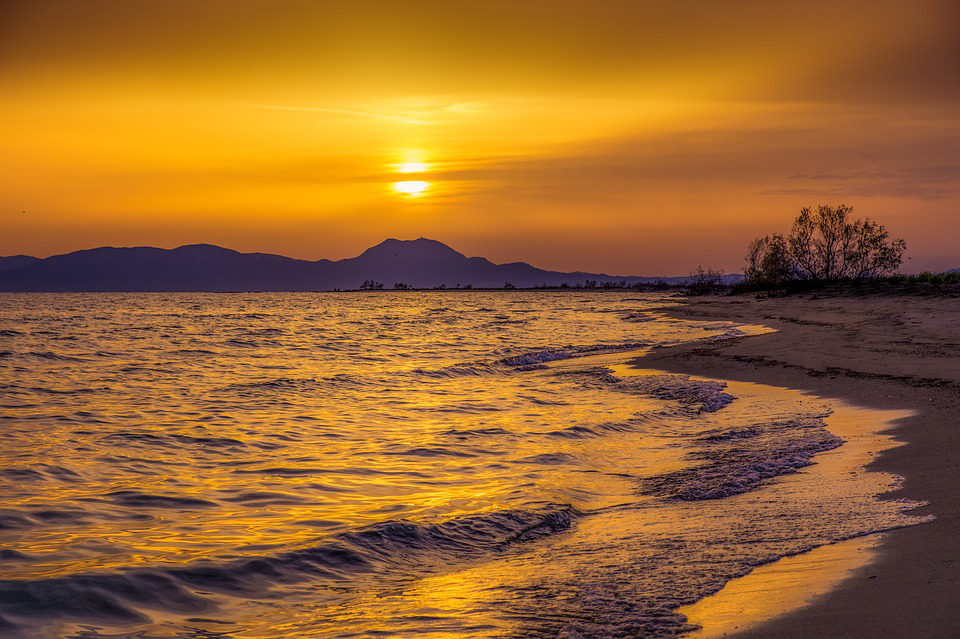

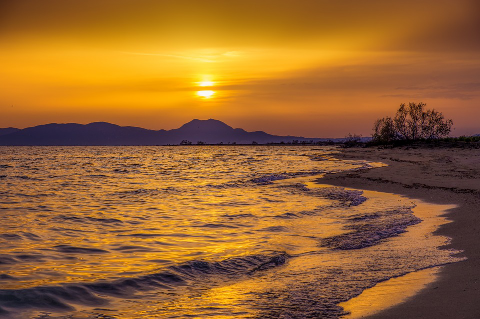

In [9]:
for i in range(2):
    x = syn_pyr(pyr[i:])
    x = trans(x[0])
    display(x)

# Pre-processing for generated image
- Show what is he output_im_temp

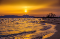

In [17]:
s_pyr = dec_pyr(img.clone(), 6)
for i in range(3):
    s_pyr[i] = s_pyr[i] * 0.

output_im_tmp = syn_pyr(s_pyr[4:])
i = trans(output_im_tmp[0])
display(i)

# 1